<a href="https://colab.research.google.com/github/ampsds/AI/blob/main/Flask_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ngrokのアクセストークン取得
https://ngrok.com/
サインアップ後、Your Authtokenからトークンをコピー

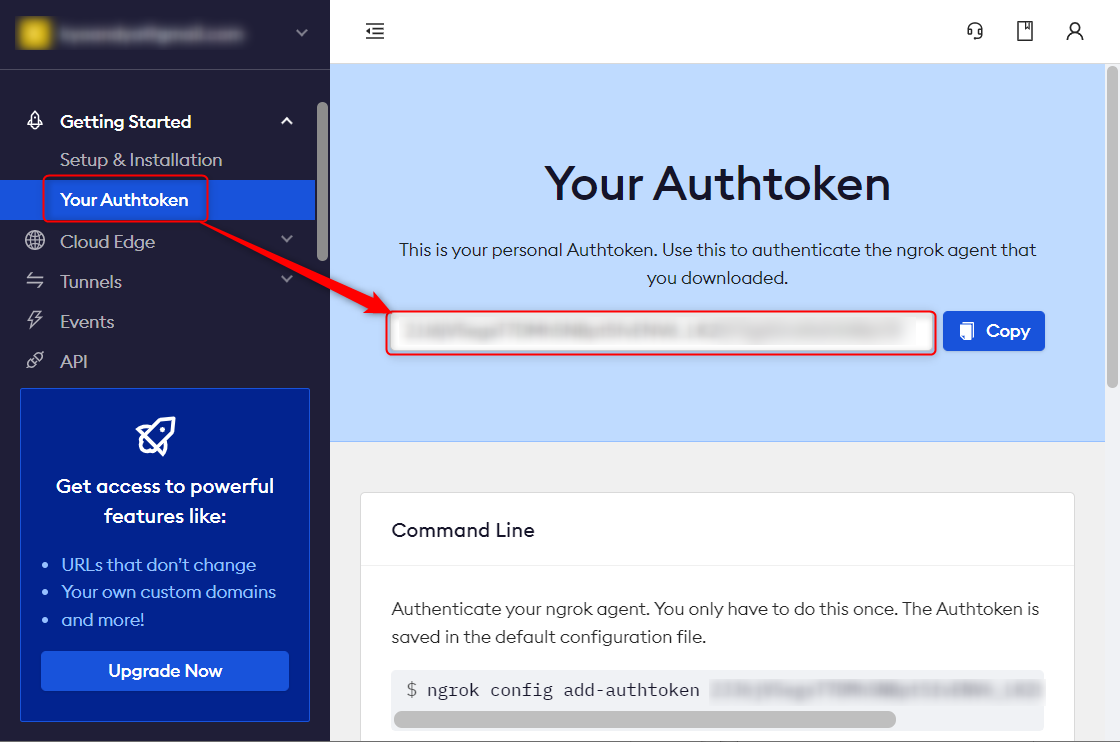

In [ ]:
%matplotlib inline
!pip install Flask==1.0.3 -q
!pip install -U flask-cors -q
!pip install flask-ngrok -q
!pip install pyngrok -q
!ngrok authtoken <アクセストークン> #上でコピーしたトークンを貼り付け


#ImageNetのクラスIDとクラス名のJSONをダウンロード
https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

ダウンロードしたJSONをファイルに追加する

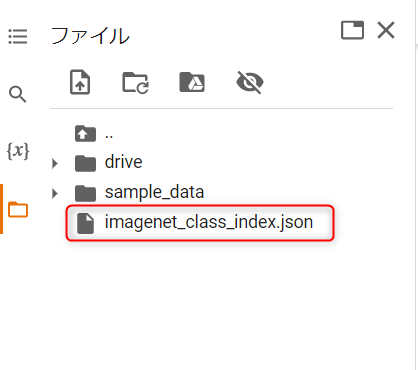

#Flask実行

In [ ]:
import io
import json

from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok
from flask_cors import CORS

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)

imagenet_class_index = json.load(open('imagenet_class_index.json'))

model = models.resnet50(pretrained=True)

model.eval()


def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = str(y_hat.item())
    return imagenet_class_index[predicted_idx]

@app.after_request
def after_request(response):
  # response.headers.add('Access-Control-Allow-Origin', '*')
  response.headers.add('Access-Control-Allow-Headers', 'Content-Type')
  response.headers.add('Access-Control-Allow-Methods', 'GET,PUT,POST,DELETE,OPTIONS')
  return response

@app.route('/')
def index():
  return '''
    <form method="post" enctype="multipart/form-data" action="/predict">
      <input type="file" name="file">
      <input type="submit">
    </form>
  '''

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
        class_id, class_name = get_prediction(image_bytes=img_bytes)
        return jsonify({'class_id': class_id, 'class_name': class_name})


if __name__ == '__main__':
    app.run()

# 画像判別実行
Running onのURLをクリック

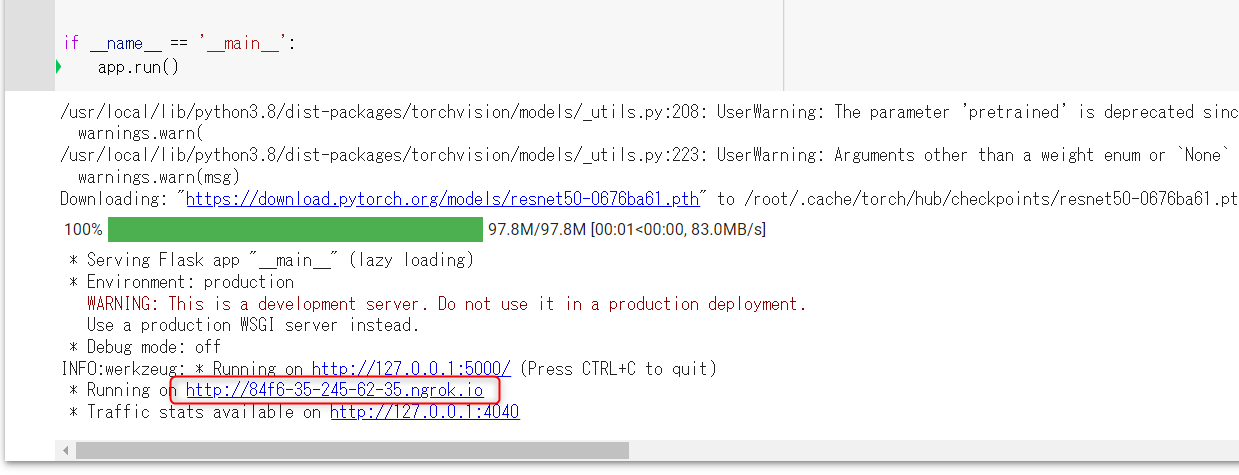

Visit Siteをクリック

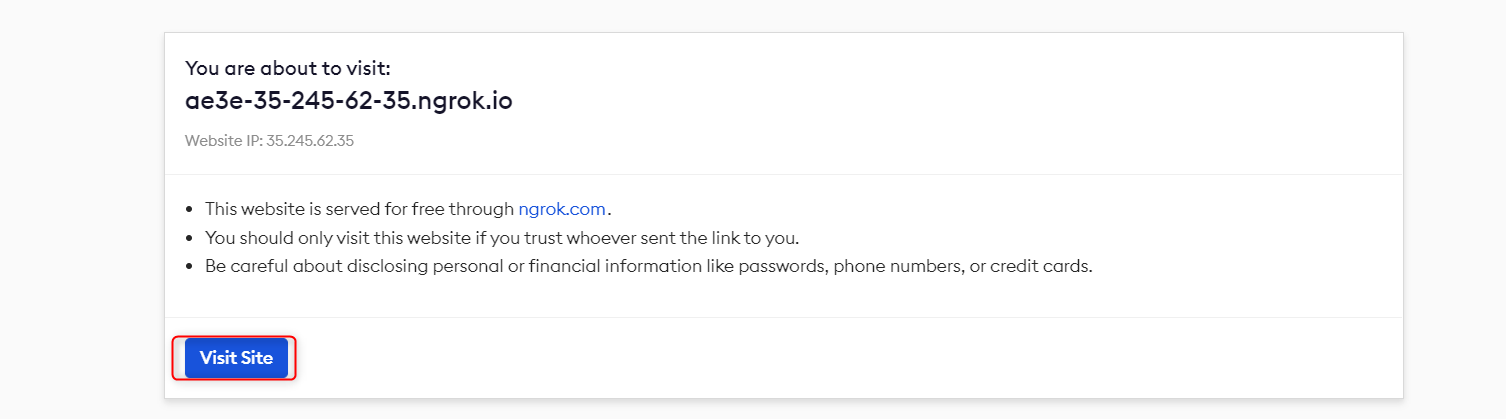

開いた画面でファイルを選択する

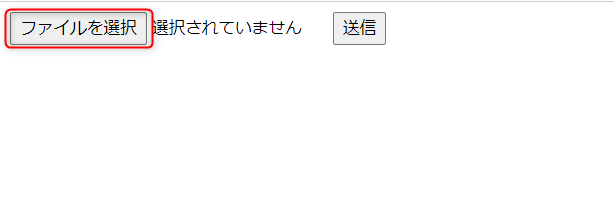

判別したい画像を選択して開く

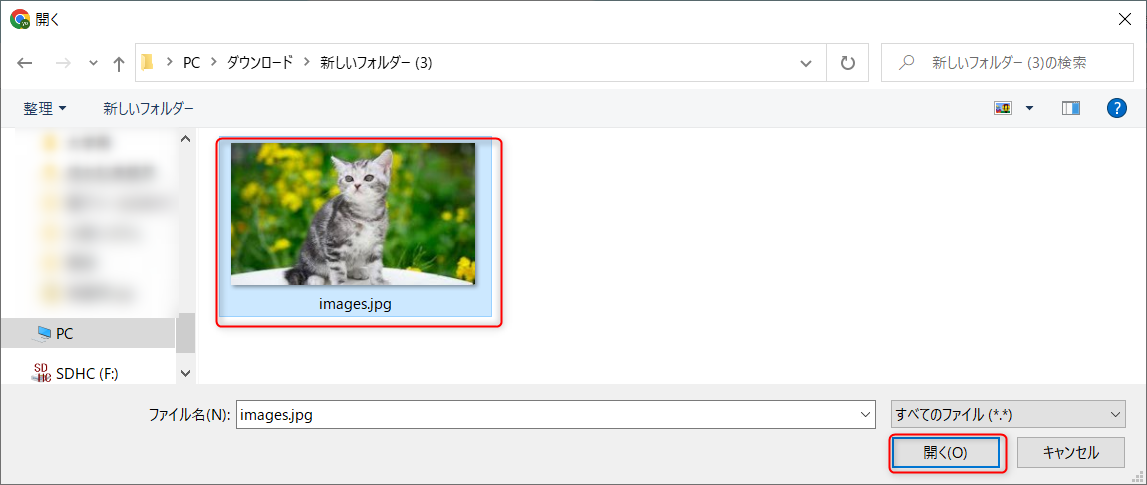

送信をクリック

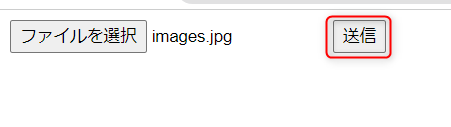

判別結果が表示される

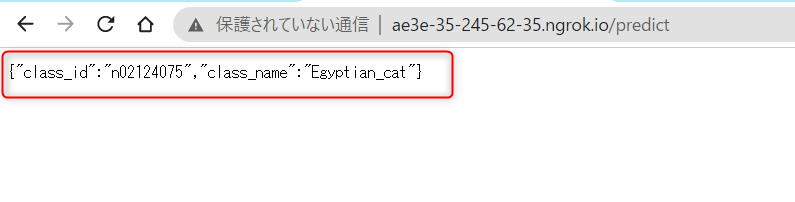